In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

import atmos

In [3]:
activity_df = pd.read_clipboard(names=['time','distance','power','cadence','heartrate','speed','altitude','lat','long','slope'])
activity_df['speed'] = activity_df['speed']*1000/60/60
activity_df['acceleration'] = (activity_df['speed']-activity_df['speed'].shift(1))

In [2]:
weather_df = pd.read_clipboard(names=['Time','distance','TEMPERATURE','HUMIDITY','WINDSPEED','WINDDIRECTION','PRESSURE'])

In [5]:
activity_df.to_parquet('activity_data')
weather_df.to_parquet('weather_data')

In [15]:
intervals = [(15*60+15,16*60+47)]

In [31]:
closest_weather_reading_idx = abs((weather_df['Time'] - intervals[0][0]) + (weather_df['Time'] - intervals[0][1])).argmin()
closest_weather_reading = weather_df.loc[closest_weather_reading_idx]
rho_inputs = {'p':closest_weather_reading['PRESSURE']
             ,'T':273+closest_weather_reading['TEMPERATURE']
             ,'RH':closest_weather_reading['HUMIDITY']/100}

In [33]:
rho = atmos.calculate('rho', **rho_inputs)

In [52]:
Crr = .005
CdA = .3
athlete_mass = 84
bike_mass = 7.6
gear_mass = 1.5
system_mass = athlete_mass + bike_mass + gear_mass
gravity = 9.81

In [53]:
def solve_power(Crr, m, g, v, s, a, CdA, rho, v_air):

    return w
def solve_power_nowind(Crr, m, g, v, a, CdA, rho, w):
    s = w / (m*g*v) - Crr - a/g - (rho*CdA*v**2)/(2*m*g)
    return s

## Test function & dataflow

In [61]:
pred_slope_change = solve_power_nowind(Crr=Crr, CdA=CdA, m=system_mass, g=gravity, v=activity_df['speed'], a=activity_df['acceleration'], rho=rho, w=activity_df['power'])
pred_elevation = pred_slope_change.fillna(0).cumsum()
pred_elevation.plot()

<AxesSubplot:>

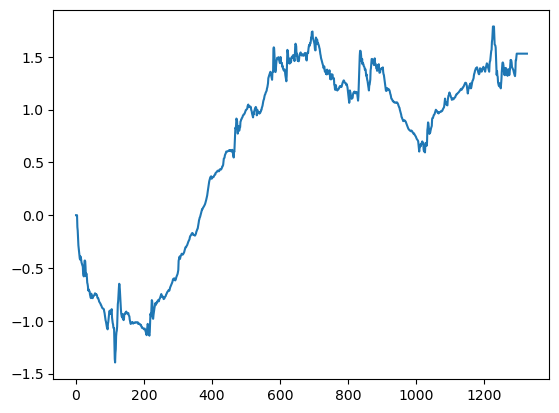

In [63]:
pred_elevation.plot()

In [68]:
def optimize_CdA(params):    
    losses = []

    pred_slope_change = solve_power_nowind(Crr=params[1], CdA=params[0], m=system_mass, g=gravity, v=activity_df['speed'], a=activity_df['acceleration'], rho=rho, w=activity_df['power'])
    
    losses = abs(activity_df['altitude'] - pred_slope_change)
    MAE = np.mean(losses)
    print(MAE)
    return MAE
                # CdA  Crr
initial_guess  = [.3, .005]
modeled_CdA = scipy.optimize.minimize(optimize_CdA
                                            ,x0=initial_guess
                                                    # CdA          Crr
                                            ,bounds=[(.15,0.40),(.004,0.007)]
                                            # ,method='Nelder-Mead'
                                            # ,tol=1e-8
                                            )
print(modeled_CdA)
for val in modeled_CdA['x']:
    print(val)

8.598969351612796
8.598969352077331
8.598969361612792
8.595811348157982
8.59581134862254
8.595811358158002
8.59365323742604
8.593653237890607
8.59365324742605
8.591001083035739
8.591001083500302
8.591001093035752
      fun: 8.591001083035739
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.04645635, 1.00000133])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 2
     njev: 4
   status: 0
  success: True
        x: array([0.15 , 0.004])
0.15000000000000002
0.004
